# Garbage Classification using PyTorch

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.


![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)


In this notebook we'll use PyTorch for classifying trash into various categories like metal, cardboard, etc.

Let us start by importing the libraries:

In [1]:
import os, time, pathlib, random, pickle
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np

config = {'dataset': 'recycle-small', 'model': 'inception', 'num_layers_to_train': 7, 'use_model_cache': True }

def config_to_fn(cfg):
    return f'{cfg["model"]}-{cfg["dataset"]}-{cfg["num_layers_to_train"]}'

model_dir = pathlib.Path('./models')
history_dir = pathlib.Path('./histories')

for dirp in [model_dir, history_dir]:
    dirp.mkdir(exist_ok=True)

imagesize = 299 if config['model'] == 'inception' else 256

Let us see the classes present in the dataset:

## Transformations:

Now, let's apply transformations to the dataset and import it for use.

We'll split the dataset into training, validation and test sets

and we'll create training and validation dataloaders using `DataLoader`.

In [2]:

#follows https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
batch_size = 32

data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(imagesize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms_val = transforms.Compose([
        transforms.Resize(imagesize),
        transforms.CenterCrop(imagesize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


print("Initializing Datasets and Dataloaders...")
if config['dataset'] == 'recycle':
    data_dir = pathlib.Path('data/recycle/')
elif config['dataset'] == 'recycle-small':
    data_dir = pathlib.Path('data/recycle-small/')
else:
    data_dir = pathlib.Path('data/garbage/')

# Create training and validation datasets
train_ds = ImageFolder(data_dir/'train', data_transforms_train)
val_ds = ImageFolder(data_dir/'val', data_transforms_val)
test_ds = ImageFolder(data_dir/'test', data_transforms_val)
# Create training and validation dataloaders
train_dl= torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl= torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_dl= torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    

    

Initializing Datasets and Dataloaders...


In [3]:
print(len(train_ds), len(val_ds))


1658 398


Let's create a helper function to see the image and its corresponding label:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", train_ds.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: boxes (Class No: 0)


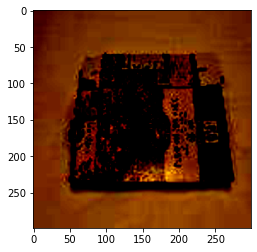

In [5]:
img, label = val_ds[1]
show_sample(img, label)

In [6]:
img.shape

torch.Size([3, 299, 299])

# Loading and Splitting Data:

This is a helper function to visualize batches:

In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


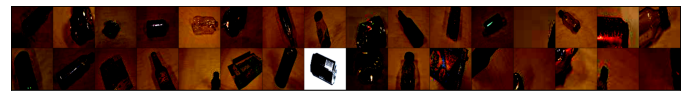

In [8]:
show_batch(train_dl)

# Model Base:

Let's create the model base:

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, {}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc'], time.time()))

We'll be using ResNet50 or Inception V3 for classifying images:

In [10]:
num_trainable_layers = config['num_layers_to_train']


class InceptionV3(ImageClassificationBase):
    def __init__(self):
        global num_trainable_layers
        super().__init__()
        # Use a pretrained model
        self.network = models.inception_v3(pretrained=True)
        
        #freeze the first 7 layers
        ct = 0
        numlayers = len(list(self.network.children()))
        if num_trainable_layers == 'all':
            num_trainable_layers = numlayers
      
        for child in self.network.children():
            ct += 1
            
            if ct > numlayers - num_trainable_layers:
                break
            #print(f'{ct} {child.__class__}')
            
            
            for param in child.parameters():
                param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        # Replace last layer
        num_ftrs = self.network.AuxLogits.fc.in_features
        self.network.AuxLogits.fc = nn.Linear(num_ftrs, len(train_ds.classes))
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return self.network(xb)  
        #return torch.sigmoid(self.network(xb))
    
    def training_step(self, batch):
        images, labels = batch 
        inception_output = self.network(images)                  # Generate predictions
        #loss1 = F.cross_entropy(torch.sigmoid(inception_output.logits), labels)   # Calculate loss
        #loss2 = F.cross_entropy(torch.sigmoid(inception_output.aux_logits), labels)
        loss1 = F.cross_entropy(inception_output.logits, labels)   # Calculate loss
        loss2 = F.cross_entropy(inception_output.aux_logits, labels)
        
        return loss1 + 0.4*loss2 #taken from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    
class ResNetXfer(ImageClassificationBase):
    def __init__(self):
        global num_trainable_layers
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        
        #freeze the first 7 layers
        ct = 0
        numlayers = len(list(self.network.children()))
        if num_trainable_layers == 'all':
            num_trainable_layers = numlayers
        for child in self.network.children():
            ct += 1
            
            if ct > numlayers - num_trainable_layers:
                break
            #print(f'{ct} {child.__class__}')
            
            for param in child.parameters():
                param.requires_grad = False

        # Parameters of newly constructed modules have requires_grad=True by default
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return self.network(xb)
        #return torch.sigmoid(self.network(xb))


xfer = True
ModelClass = InceptionV3 if config['model'] =='inception' else ResNetXfer

model_cache_path = pathlib.Path(model_dir / f"{config_to_fn(config)}.model")
if config['use_model_cache'] and model_cache_path.exists():
    model = torch.load(model_cache_path)
    print(f'loaded model from {model_cache_path}, not training')
    config['model_is_trained'] = True
else:
    model = ModelClass()
    config['model_is_trained'] = False

In [11]:
for c in model.network.children():
    print(f'{c.__class__} {[p.requires_grad for p in c.parameters()]}')

<class 'torchvision.models.inception.BasicConv2d'> [False, False, False]
<class 'torchvision.models.inception.BasicConv2d'> [False, False, False]
<class 'torchvision.models.inception.BasicConv2d'> [False, False, False]
<class 'torch.nn.modules.pooling.MaxPool2d'> []
<class 'torchvision.models.inception.BasicConv2d'> [False, False, False]
<class 'torchvision.models.inception.BasicConv2d'> [False, False, False]
<class 'torch.nn.modules.pooling.MaxPool2d'> []
<class 'torchvision.models.inception.InceptionA'> [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
<class 'torchvision.models.inception.InceptionA'> [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
<class 'torchvision.models.inception.InceptionA'> [False, False, False, False, False, False, False, False, False, False, False, False, False, F

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

InceptionV3(
  (network): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): Bas

# Training the Model:

This is the function for fitting the model.

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = to_device(model, device)
history = []

In [17]:
evaluate(model, val_dl)

{'val_loss': 1.6493622064590454, 'val_acc': 0.14010988175868988}

Let's start training the model:

In [18]:
num_epochs = 8
opt_func = torch.optim.Adam
history_cache_path = pathlib.Path(history_dir / f"{config_to_fn(config)}.history")

lr = 5.5e-5

if not config['model_is_trained']:
    starttime = time.time()
    print(starttime)
    history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

    print(time.time() - starttime)
    
    with history_cache_path.open('wb') as hf:
        pickle.dump(history, hf)
    print(f'history saved to {history_cache_path}')
    
    torch.save(model, model_cache_path)
    print(f'model saved to {model_cache_path}')
    
else:
    print(f'not training, model loaded from cache')
    if history_cache_path.exists() and history_cache_path.stat().st_size > 0:
        with history_cache_path.open('rb') as hf:
            history = pickle.load(hf)
        print(f'history loaded from {history_cache_path}')


1642964844.8229256
Epoch 1: train_loss: 1.5798, val_loss: 0.4803, val_acc: 0.8585, 1642964872.2511718
Epoch 2: train_loss: 0.8249, val_loss: 0.2556, val_acc: 0.9176, 1642964899.8780997
Epoch 3: train_loss: 0.6461, val_loss: 0.1897, val_acc: 0.9481, 1642964927.641388
Epoch 4: train_loss: 0.5080, val_loss: 0.1502, val_acc: 0.9495, 1642964955.4976678
Epoch 5: train_loss: 0.4214, val_loss: 0.1142, val_acc: 0.9567, 1642964983.5280194
Epoch 6: train_loss: 0.4078, val_loss: 0.1106, val_acc: 0.9615, 1642965011.6019418
Epoch 7: train_loss: 0.3792, val_loss: 0.0974, val_acc: 0.9736, 1642965039.5222292
Epoch 8: train_loss: 0.3688, val_loss: 0.0817, val_acc: 0.9663, 1642965067.3796468
222.5618097782135
history saved to histories/inception-recycle-small-7.history
model saved to models/inception-recycle-small-7.model


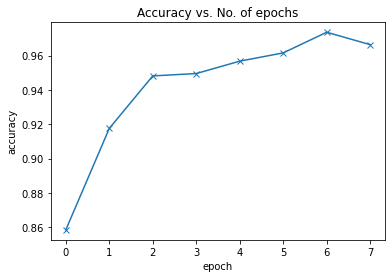

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

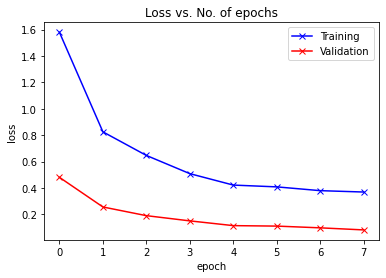

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [21]:
evaluate(model, test_dl)

{'val_loss': 0.06894098967313766, 'val_acc': 0.9797794222831726}

In [22]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: boxes , Predicted: boxes


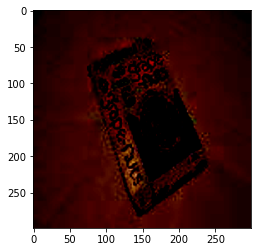

In [23]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: boxes , Predicted: boxes


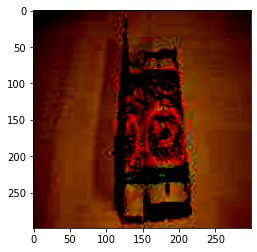

In [24]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: boxes , Predicted: boxes


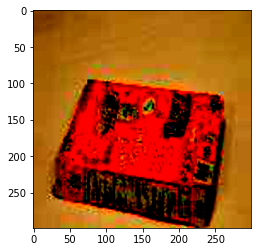

In [25]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: crushed_soda_cans , Predicted: crushed_soda_cans


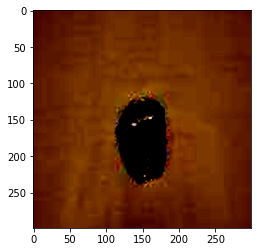

In [26]:
img, label = test_ds[random.randint(0,len(test_ds))]
plt.imshow(img.permute(1, 2, 0))

print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [27]:
import urllib.request
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fengage.vic.gov.au%2Fapplication%2Ffiles%2F1415%2F0596%2F9236%2FDSC_0026.JPG&f=1&nofb=1", "plastic.jpg")
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fi.ebayimg.com%2Fimages%2Fi%2F291536274730-0-1%2Fs-l1000.jpg&f=1&nofb=1", "cardboard.jpg")    
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", "cans.jpg") 
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftinytrashcan.com%2Fwp-content%2Fuploads%2F2018%2F08%2Ftiny-trash-can-bulk-wine-bottle.jpg&f=1&nofb=1", "wine-trash.jpg")
#urllib.request.urlretrieve("http://ourauckland.aucklandcouncil.govt.nz/media/7418/38-94320.jpg", "paper-trash.jpg")
urllib.request.urlretrieve("https://149366112.v2.pressablecdn.com/wp-content/uploads//2012/10/Paper-Waste-Go-Paperless.jpeg", "paper-trash.jpg")

('paper-trash.jpg', <http.client.HTTPMessage at 0x7f7be9a726a0>)

This function takes the image's name and prints the predictions:

In [28]:
from PIL import Image

def predict_external_image(image_name):
    image = Image.open(pathlib.Path('./' + image_name))

    example_image = data_transforms_val(image)
    plt.imshow(example_image.permute(1, 2, 0))

    print("The image resembles", predict_image(example_image, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles boxes


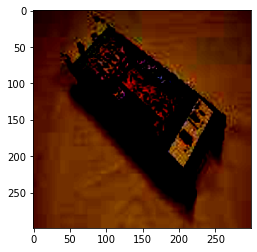

In [29]:
predict_external_image('data/recycle-small/test/boxes/1046.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles soda_cans


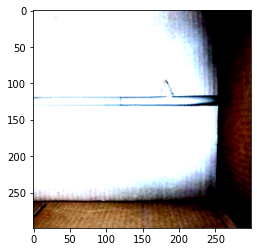

In [30]:
predict_external_image('data/garbage/test/cardboard/cardboard102.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles soda_cans


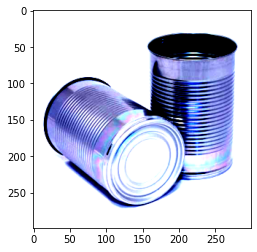

In [31]:
predict_external_image('cans.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles soda_cans


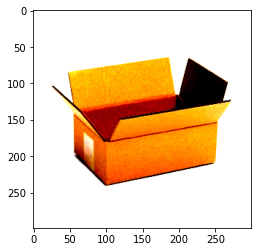

In [32]:
predict_external_image('cardboard.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles water_bottles


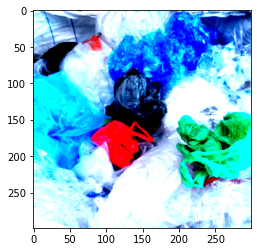

In [33]:
predict_external_image('plastic.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles glass_bottles


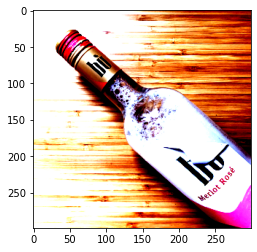

In [34]:
predict_external_image('wine-trash.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image resembles glass_bottles


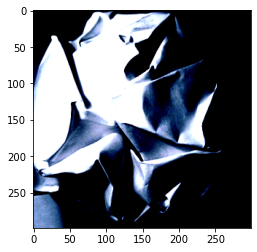

In [35]:
predict_external_image('paper-trash.jpg')